Initializing Packages

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

Section 1: Loading in the data and storing it as lists

In [122]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [123]:
directory = "team_battery"

# Regex to capture the float X from filenames like cal_10_(X).mca
pattern = re.compile(r"ba_\d+\_(\d*)\.mca")

# Temporary storage for (x_value, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        x_value = float(match.group(1))
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((x_value, data))

# Sort by x_value
temp_storage.sort(key=lambda item: item[0])

# Separate into two lists 
file_labels = [item[0] for item in temp_storage]
all_data_lists = [item[1] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
for i, data_list in enumerate(all_data_lists):
    print(f"File {i+1} (X={file_labels[i]}): {len(data_list)} points")
    
# The data is stored in acdending order of bias voltage in the all_data_lists and file lables are the bias voltages

Loaded 24 files in ascending order of X.
File 1 (X=1157.0): 1024 points
File 2 (X=1207.0): 1024 points
File 3 (X=1258.0): 1024 points
File 4 (X=1309.0): 1024 points
File 5 (X=1309.0): 1024 points
File 6 (X=1359.0): 1024 points
File 7 (X=1410.0): 1024 points
File 8 (X=1459.0): 1024 points
File 9 (X=1459.0): 1024 points
File 10 (X=1509.0): 1024 points
File 11 (X=1559.0): 1024 points
File 12 (X=1559.0): 1024 points
File 13 (X=1610.0): 1024 points
File 14 (X=1659.0): 1024 points
File 15 (X=1659.0): 1024 points
File 16 (X=1709.0): 1024 points
File 17 (X=1760.0): 1024 points
File 18 (X=1760.0): 1024 points
File 19 (X=1809.0): 1024 points
File 20 (X=1859.0): 1024 points
File 21 (X=1910.0): 1024 points
File 22 (X=1960.0): 1024 points
File 23 (X=2010.0): 1024 points
File 24 (X=2121.0): 1024 points


In [124]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')
# Initialising the background
channel_no=np.linspace(0,len(all_data_lists[index]),1024)

In [125]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))
#defining the gaussian

Creating functions to run withing loops (The names are self explainatory)

In [126]:
def bkg_corrector(bkg_list,data_list,index):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[index][i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [127]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess)
    gauss=gaussian(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [128]:
## THRESHOLD
# def peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,threshold_lvl,bkg,all_data_lists):
#     peak_pnts=[]
#     range_list=[]
#     p0_list=[]
#     bkg_corr_ind=bkg_corrector(bkg,all_data_lists,index)
#     peaks, properties = fp.find_peaks(
#         bkg_corr_ind,
#         height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
#         distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
#         width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
#         prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
#         rel_height=0.5,
#         threshold=threshold_lvl
#     )
    
#     peak_bins = peaks
#     peak_positions = channel_no[peak_bins]
#     peak_width= properties["widths"]
#     peak_heights=properties["peak_heights"]
#     # print("Peak bins:", peak_bins)
#     print("Rough peak positions:", peak_positions)
#     print("NO. PEAKS DETECTED:", len(peak_positions))
#     # print("Peak widths:", peak_width)
#     print("Peak heights:", peak_heights)
    
#     for i in peak_bins:
#         peak_ind=bkg_corr_ind[i]
#         peak_pnts.append(peak_ind)
        
#     for i in range(0,len(peak_bins)):
#         lower_lim=peak_bins[i]-peak_width[i]/2
#         upper_lim=peak_bins[i]+peak_width[i]/2
#         fit_range=[int(lower_lim+1),int(upper_lim+1)]
#         range_list.append(fit_range)
#         a_est=peak_heights[i]
#         mu_est=peak_positions[i]
#         sigma_est = peak_width[i]
#         init_guess=[a_est,mu_est,sigma_est]
#         p0_list.append(init_guess)
#         # range.clear()
        
#     # peak_pnts.clear()
#     return peak_pnts,peak_bins,peak_positions,peak_width,range_list,p0_list,bkg_corr_ind

In [129]:
# NO THRESHOLD
def peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists):
    peak_pnts=[]
    range_list=[]
    p0_list=[]
    bkg_corr_ind=bkg_corrector(bkg,all_data_lists,index)
    peaks, properties = fp.find_peaks(
        bkg_corr_ind,
        height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
        distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
        width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
        prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
        rel_height=0.5
    )
    
    peak_bins = peaks
    peak_positions = channel_no[peak_bins]
    peak_width= properties["widths"]
    peak_heights=properties["peak_heights"]
    # print("Peak bins:", peak_bins)
    print("Rough peak positions:", peak_positions)
    print("NO. PEAKS DETECTED:", len(peak_positions))
    # print("Peak widths:", peak_width)
    print("Peak heights:", peak_heights)
    
    for i in peak_bins:
        peak_ind=bkg_corr_ind[i]
        peak_pnts.append(peak_ind)
        
    for i in range(0,len(peak_bins)):
        lower_lim=peak_bins[i]-2*peak_width[i]
        upper_lim=peak_bins[i]+2*peak_width[i]/2
        fit_range=[int(lower_lim+1),int(upper_lim+1)]
        range_list.append(fit_range)
        a_est=peak_heights[i]
        mu_est=peak_positions[i]
        sigma_est = peak_width[i]
        init_guess=[a_est,mu_est,sigma_est]
        p0_list.append(init_guess)
        # range.clear()
        
    # peak_pnts.clear()
    return peak_pnts,peak_bins,peak_positions,peak_width,range_list,p0_list,bkg_corr_ind

In [130]:
manual_fit_list=[[[55.0, 72.0]], [[71.0, 90.0]], [[99.0, 116.0]], [[51.0, 58.0], [135.0, 156.0]], [[27.0, 32.0], [54.0, 63.0]], [[27.0, 34.0], [72.0, 83.0]], [[30.0, 47.0], [99.0, 112.0]], [[26.0, 31.0], [65.0, 74.0]], [[48.0, 71.0], [132.0, 149.0]], [[33.0, 48.0], [90.0, 101.0]], [[62.0, 69.0]], [[47.0, 64.0], [92.0, 99.0], [125.0, 138.0], [143.0, 150.0]], [[32.0, 45.0], [87.0, 98.0]], [[36.0, 53.0], [120.0, 133.0]], [[49.0, 56.0]], [[28.0, 33.0], [69.0, 78.0]], [[48.0, 55.0]], [[29.0, 42.0], [96.0, 111.0]], [[28.0, 33.0], [67.0, 76.0]], [[28.0, 45.0], [94.0, 109.0]], [[42.0, 65.0], [136.0, 155.0]], [[74.0, 83.0], [193.0, 222.0]], [[1.0, 121.0], [263.0, 324.0]], [[600.0, 770.0] , [190,350]]]
num_peak_list=[1,1,1,2,2,2,2,2,2,2,1,2,2,2,1,2,1,2,2,2,2,2,2,2]
print(len(num_peak_list))

24


In [131]:
def graphfitter(range_list,num_peak,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peak_num in num_peak:
        for peaks in range(0,peak_num-1):
            ranged_channel,fit_gauss,mu,cov = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
            ranged_channel_list.append(ranged_channel)
            fit_gauss_list.append(fit_gauss)
            centroid_error=np.sqrt(np.diag(cov))
            print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
            print(f"The centroid for peak {peaks}:",mu[1])
            print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
        return ranged_channel_list, fit_gauss_list

In [132]:
index=11
minimum_expected_peak_height=43
minimum_bin_distance_between_peaks=15
minimum_peak_width=4
maximum_peak_width=200
minimum_peak_prominence=None
threshold=13

In [133]:
# def graphfitter(range_list,function,channels,bkg_corr_data,p0_list):
#     ranged_channel_list=[]
#     fit_gauss_list=[]
#     for peaks in range(0,len(range_list)):
#         ranged_channel,fit_gauss,mu,cov  = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
#         ranged_channel_list.append(ranged_channel)
#         fit_gauss_list.append(fit_gauss)
#         centroid_error=np.sqrt(np.diag(cov))
#         print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
#         print(f"The centroid for peak {peaks}:",mu[1])
#         print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
#     return ranged_channel_list, fit_gauss_list

Test section to fit and run per voltage fits

In [134]:
# peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list, bkg_corr_ind  =  peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,threshold,bkg,all_data_lists)

In [135]:
# ranged_channel_list,fit_gauss_list = graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)

In [136]:
# #plotting the curve and the peaks (Still working on the automatic fitting, worst case scenario we can just manually fit the curves)
# peakcolors=len(ranged_channel_list)
# peaklegend=plt.cm.PRGn(np.linspace(0,1,peakcolors))
# fig, ax = plt.subplots()
# ax.plot(channel_no,all_data_lists[index],label=file_labels[index],color='grey',linestyle='dotted')
# ax.plot(channel_no,bkg,label='background',color='green',linestyle='dotted')
# ax.plot(channel_no,bkg_corr_ind,label=f'bkg corr {file_labels[index]}',color='violet')
# ax.plot(peak_positions,peak_pnts,'r.')
# for fitpeak in range(0,len(ranged_channel_list)):
#     ax.plot(ranged_channel_list[fitpeak],fit_gauss_list[fitpeak],color=peaklegend[fitpeak])
# ax.legend()
# plt.xlim(0,200)
# plt.show()
# print("Initial guess list",p0_list)
# print("Fitting range for each peak",range_list)




Trying a loop to fit all the possible peaks for bias voltage

In [137]:
# for bias_voltage in range(0,len(all_data_lists)):
#     print("BIAS VOLTAGE",file_labels[bias_voltage],": Index",bias_voltage)
#     peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list,bkg_corr_ind  =  peak_scouter(bias_voltage,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)
#     # graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)
    

Final Histogram plotting

In [138]:
numline=len(all_data_lists)
colour=plt.cm.plasma(np.linspace(0,1,numline))

In [147]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    plt.plot(np.linspace(0,len(data_list[index]),1024),bkg_correction,label=f"corrected {label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.xlabel("Channel Number")
    plt.ylabel("Counts")
    plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


In [148]:
def hist_generator(index,data_list,bkg,label_list,color):
    # bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    plt.plot(np.linspace(0,len(data_list[index]),1024),all_data_lists[index],label=f"{label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.xlabel("Channel Number")
    plt.ylabel("Counts")
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


The line at 200 is just an arbitrary level I used to check if my background deletion is working

In [141]:
channel_no = np.linspace(0, 1024, 1024)

def plot_all_spectra_with_fits(all_data_lists, bkg, file_labels,range_list):
    n = len(all_data_lists)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.5*n), sharex=True)
    if n == 1:
        axes = [axes]

    all_fit_ranges = []   # will hold ranges for each spectrum

    for idx in range(n):
        print("PEAK:", idx)
        ax = axes[idx]

        # Background-corrected data
        bkg_corr = bkg_corrector(bkg, all_data_lists, idx)

        # Find peaks and fitting parameters with your peak_scouter
        (peak_pnts, peak_bins, peak_positions,
         peak_width, pre_range_list, p0_list, bkg_corr_ind) = peak_scouter(
            idx,
            minimum_expected_peak_height,
            minimum_bin_distance_between_peaks,
            minimum_peak_width,
            maximum_peak_width,
            minimum_peak_prominence,
            bkg,
            all_data_lists
        )

        # Convert this spectrum's ranges to [[x1, x2], [x3, x4], ...]
        this_fit_ranges = [[float(r[0]), float(r[1])] for r in range_list]
        all_fit_ranges.append(this_fit_ranges)

        # Plot spectrum
        ax.plot(channel_no, bkg_corr, label=f"corrected {file_labels[idx]}", color="C0")

        # Only plot peak positions as points, no fits
        for bin_idx in peak_bins:
            x = channel_no[bin_idx]
            y = bkg_corr[bin_idx]
            ax.plot(x, y, "ro")  # red dot at peak maximum

        # ax.axhline(30, color="black", linestyle="dashed", linewidth=0.7)
        ax.set_ylabel("Counts")
        ax.legend(loc="upper right")
        ax.set_title(f"Bias {file_labels[idx]} (index {idx})")

        # set x-limits here
        ax.set_xlim(0, 400)

    axes[-1].set_xlabel("Channel")
    plt.tight_layout()
    plt.show()

    print("All fit ranges:", all_fit_ranges)
    return all_fit_ranges

# Call it:
fit_ranges = plot_all_spectra_with_fits(all_data_lists, bkg, file_labels)


TypeError: plot_all_spectra_with_fits() missing 1 required positional argument: 'range_list'

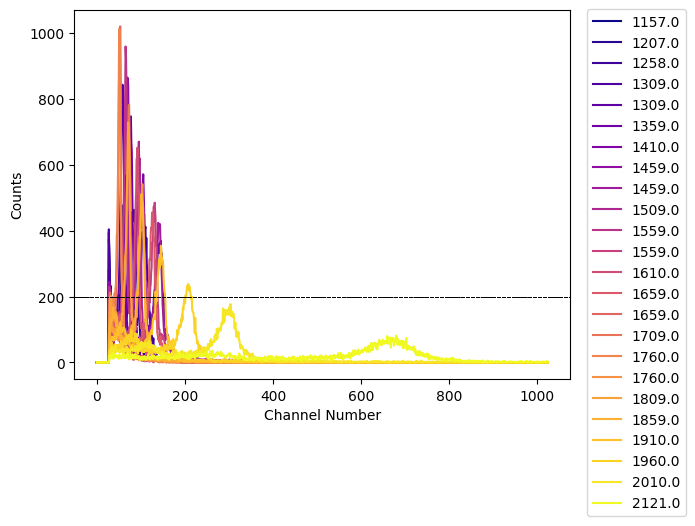

In [149]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,bkg,file_labels,colour[i])
    

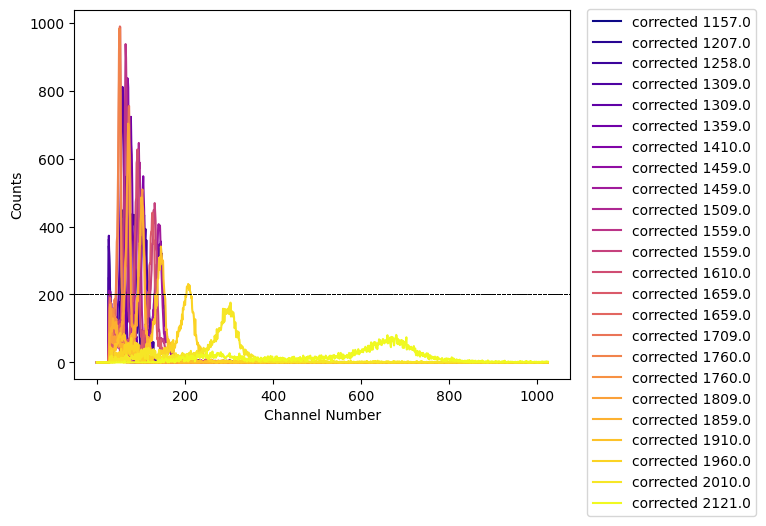

In [150]:
for i in range(0,len(all_data_lists)):
    hist_generator_bkg_corrected(i,all_data_lists,bkg,file_labels,colour[i])
    